## Red Rock Canyon Data Project

Las Vegas is known for many things. The night life, the casinos, it's history with the "mob", and of course, the fact that it's a large city plopped down in the middle a desert. Although I've lived here for all of my adult life, I've never been the type of person that was interested in clubs or partying. I'm also not particularly fond of betting or gambling large sums of money. But, if there's one thing that's underrated about Las Vegas, I would sayz it's the nature. Now, I know what you're thinking, what's so cool about a desert landscape? Well, if it was a flat desert, I'd probably just agree with you. However, they call it the Las Vegas *Valley* for a reason. The city is surrounded by mountains. No matter what direction you look in, you can find a mountain range of some sort, and with mountains comes one of my favorite activities, **hiking!** 

To the west of Las Vegas lies the Red Rock Canyon. Recently, while looking a few hiking trails on the [official Red Rock Canyon website](https://www.redrockcanyonlv.org/), I noticed that each trail had metrics placed on their corresponding web page. Me being the type of person I am (*read: Nerd*), the first thing that came to my mind was, "This is **DATA**". So with that, a new project was born. This blog post is going to detail the steps I went through while completing this project. 

First things first, as with any project, one must lay out their plan and decide what tools they're going to use. This project was pretty small so I only needed to import a handful of libraries. I'm not going to go into detail about each individual library, but here are the ones that I put to use.  

In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
import requests
import numpy as np
import seaborn as sns


After importing the above libraries, my next goal was to scrap Red Rock Canyon's web pages for the information needed. A combination of the libraries Requests and bs4/BeautifulSoup  made this fairly simple to do. 

In [4]:

#Setting user agent to prevent errors associated with "empty" user agents when doing an http request.
user_agent = {'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36'}

#Using requests to retrieve both html pages containing the target data. 
trails_page = requests.get(url = 'https://www.redrockcanyonlv.org/lasvegas/hikes-trails/', headers = user_agent).text
trails_page2 = requests.get(url = 'https://www.redrockcanyonlv.org/lasvegas/hikes-trails/page/2/',headers = user_agent).text

#Creating BeautifulSoup objects using the html pages we requested.
trails_soup = BeautifulSoup(trails_page, 'html.parser')
trails_soup2 = BeautifulSoup(trails_page2, 'html.parser')


#Two List comprehensions to create a list of "Trail Urls" from our trails_soup objects. Finds all h2 tags with the class 'the-title'.
#Then uses the object created from find_all() to get 'href' from 'a' tags. 
page1_list = [x.find("a").get('href') for x in trails_soup.find_all('h2',{'class':'the-title'})]
page2_list = [x.find("a").get('href') for x in trails_soup2.find_all('h2',{'class':'the-title'})]


#Concatenate the two lists together to make one list of Urls.
trail_urls = page1_list + page2_list


Checking the results.

In [5]:
trail_urls

['https://www.redrockcanyonlv.org/moenkopi-loop/',
 'https://www.redrockcanyonlv.org/calico-hills/',
 'https://www.redrockcanyonlv.org/calico-tanks/',
 'https://www.redrockcanyonlv.org/turtlehead-peak/',
 'https://www.redrockcanyonlv.org/keystone-thrust/',
 'https://www.redrockcanyonlv.org/white-rock-willow-springs/',
 'https://www.redrockcanyonlv.org/grand-circle-loop/',
 'https://www.redrockcanyonlv.org/white-rock-la-madre-spring-loop/',
 'https://www.redrockcanyonlv.org/willow-springs-loop/',
 'https://www.redrockcanyonlv.org/la-madre-spring/',
 'https://www.redrockcanyonlv.org/petroglyph-wall-trail/',
 'https://www.redrockcanyonlv.org/north-peak-trail/',
 'https://www.redrockcanyonlv.org/bridge-mountain-trail/',
 'https://www.redrockcanyonlv.org/lost-creek-childrens-discovery/',
 'https://www.redrockcanyonlv.org/smyc/',
 'https://www.redrockcanyonlv.org/ice-box-canyon/',
 'https://www.redrockcanyonlv.org/dales/',
 'https://www.redrockcanyonlv.org/pine-creek-canyon/',
 'https://www.

With my list of URLs the next task was to go through each each trail url, and to scrape the necessary information from them. Using list comprehension I created a list of BeautifulSoup objects for each url/webpage that I gathered in the trail_urls list.  

In [6]:
trail_htmls = [BeautifulSoup(requests.get(url = link ,headers = user_agent).text, 'html.parser') for link in trail_urls]

The BeautifulSoup objects that were created above contained the information I needed. The next step was to parse through each object and compile all of the data into one dataframe.

In [7]:
#Creating DataFrame

df = pd.DataFrame({'Name': [],
                   'Distance (miles)': [],
                   'Average Time (hours)':[],
                   'Difficulty':[],
                  })
#For loop to grab needed data from Beautiful Soup objects created above.

for x in trail_htmls:
    #This grabs some metrics from the html code and then turns those metrics into a list.
    scraped_metrics = x.find_all('div',{'class':'mk-single-content clearfix'})[0].find('p').text.split(';')

    
    #This grabs <title> of the webpage in order to get the name of the trail. 
    scraped_name = x.find_all('title')[0].get_text().split('|')[0].strip()

    #This adds the trail name to the beggining of the metrics list.
    scraped_metrics.insert(0, scraped_name) 
    
    
    
    #This adds the list of information to the dataframe as row. 
    df.loc[len(df.index)] = scraped_metrics
     

Taking a look at this data, it quickly becomes obvious that there is some inconsistent formatting going on. My next task was to clean the data in so that it can be used for analysis. First let's take a quick look at how the data frame currently appears.

In [8]:
df

,Name,Distance (miles),Average Time (hours),Difficulty
0,Moenkopi Loop,Distance: 2 miles,Average time: 1.5hrs,Difficulty: EASY
1,Calico Hills,Distance 2-6 miles,Average time: 1.5 – 3.5 hrs,Difficulty: MODERATE
2,Calico Tanks,Distance 2.2 miles,Average time: 2hrs,Difficulty: MODERATE – STRENUOUS
3,Turtlehead Peak,Distance 4.6 miles,Average time: 3.5-4.5hrs,Difficulty: STRENUOUS
4,Keystone Thrust,Distance 2.4 miles,Average time: 1.5hrs,Difficulty: MODERATE
5,White Rock – Willow Springs,Distance: 4 miles,Average time: 2.5hrs,Difficulty: MODERATE
6,Grand Circle Loop,Distance: 11.4 miles,Average Time: 6 hrs,Difficulty: Strenuous
7,White Rock Mountain Loop,Distance 6.2 miles,Average time: 3.5hrs,Difficulty: STRENUOUS
8,Willow Spring Loop,Distance 1.1 miles,Average time: 1.25hrs,Difficulty: EASY
9,La Madre Spring,Distance 3.6 miles,Average time: 2hrs,Difficulty: MODERATE


In [9]:
# Cleaning data.

# Grabbing only the numeric value from distance column. 
for x,y in df.iterrows():
    y[1] = y[1].split(' ')[1]
    y[1]

#Cleaning Average Time data. 

#Stripping excess information from strings and turning values into numerics. 

for x,y in df.iterrows():
    y[2] = y[2].strip().split(':')[1].split('h')[0].strip()
    y[2]=y[2].split('-')[0]


#Petroglyph Wall had it's value as '30 minutes'.

df.loc[10,'Average Time (hours)'] = .5

#Ash Spring trail had it's value as '1/2'
df.loc[30,'Average Time (hours)'] = .5


# Cleaning to difficulty row and transforming our ordinal variables into numerical data. 

for x,y in df.iterrows():
    y[3]=y[3].split(':')[1].strip().lower()
    
# For the sake of making this analysis easier, I am turning these variables into numbered strings. 
for x,y in df.iterrows():   

    if df.loc[x,'Difficulty'] == 'easy':
        df.loc[x,'Difficulty'] = '0'
    elif df.loc[x,'Difficulty'] == 'easy-moderate':
        df.loc[x,'Difficulty'] = '1'
    elif df.loc[x,'Difficulty'] == 'easy to moderate':
        df.loc[x,'Difficulty'] = '1'
    elif df.loc[x,'Difficulty'] == 'moderate':
        df.loc[x,'Difficulty'] = '2'
    elif df.loc[x,'Difficulty'] == 'moderate - strenuous':
        df.loc[x,'Difficulty'] = '3'
    elif df.loc[x,'Difficulty'] == 'strenuous':
        df.loc[x,'Difficulty'] = '4'
        
df.loc[2,'Difficulty'] = '3'

Now let's take a quick look at how our dataframe again. 

In [12]:
df

,Name,Distance (miles),Average Time (hours),Difficulty
0,Moenkopi Loop,2,1.5,0
1,Calico Hills,2-6,1.5 – 3.5,2
2,Calico Tanks,2.2,2,3
3,Turtlehead Peak,4.6,3.5,4
4,Keystone Thrust,2.4,1.5,2
5,White Rock – Willow Springs,4,2.5,2
6,Grand Circle Loop,11.4,6,4
7,White Rock Mountain Loop,6.2,3.5,4
8,Willow Spring Loop,1.1,1.25,0
9,La Madre Spring,3.6,2,2


Looking at the above, we can quickly see that the some of the trails have a little bit of "weirdness" going on, with their "Average Times". The trail "Calico Hills" had it's value as '1.5 – 3.5'. According to it's description on the website, this is because there are multiple "versions" of the trial. This is the description given directly from the webpage.

> This trail runs along the base of the Calico Rocks from Calico Basin to Sandstone Quarry. Distance is variable since the trail can be accessed at either end or from either of the two Calico parking areas. A side trail runs from the fee booth parking lot and connects with this trail (2 – 6 miles, easy to moderate).

Now this issue, took much more time than it needed to, completely due to my own indecisiveness. My original plan was to just remove the row. But then I thought that maybe I should include each different "version" of the trail while using some sort of imputation to determine each version's Difficulty rating. I initially thought this would be a great idea, but then comes the question of how we determine the Average Time for each trail, am I going to impute that too? Even more, just looking at the [map](https://www.redrockcanyonlv.org/wp-content/uploads/calico-hills.pdf), how did they manage to get a trail length of 2 miles out of any of these sections? At the end the day I decided to just remove the row.

In regards to other trails that had non-concrete Average Times (for example Bridge Mountain), I simply chose to keep the first number listed. Unlike Calico Hills, most of these other trails didn't state the reason why they would give average time data in such a way. 




In [13]:
#Dropping Calico Hills 
df.drop(index=1,inplace = True)

Lastly we make sure all our continious  are turned to numerics. 

In [14]:
df['Average Time (hours)'] = pd.to_numeric(df['Average Time (hours)'])
df['Distance (miles)'] = pd.to_numeric(df['Distance (miles)'])

Now that our data is all cleaned up, lets take a look at some descriptive statistics. 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 30
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  30 non-null     object 
 1   Distance (miles)      30 non-null     float64
 2   Average Time (hours)  30 non-null     float64
 3   Difficulty            30 non-null     object 
dtypes: float64(2), object(2)
memory usage: 1.2+ KB


In [16]:
df.describe()

,Distance (miles),Average Time (hours)
count,30.000000,30.000000
mean,3.603333,2.241667
std,3.529040,1.430100
min,0.200000,0.500000
25%,1.625000,1.312500
50%,2.400000,2.000000
75%,4.000000,2.500000
max,15.800000,6.000000


Looking at the above table, the first thing that jumped out of me was the large gap between our 75% percentile in Distance (miles) and our max in the same parameter. Without even doing any additional math, it's very obvious that we have at least one outlier when it comes to our Distance parameter. Looking at a box plot, this becomes even more clear.

<AxesSubplot:ylabel='Distance (miles)'>

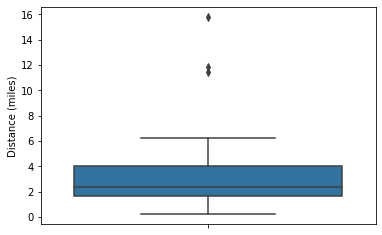

In [22]:
sns.boxplot(data = df, y="Distance (miles)")

A similar, slightly less exageratted, pattern can be seen when looking at the "Average Time" columns. 

<AxesSubplot:ylabel='Average Time (hours)'>

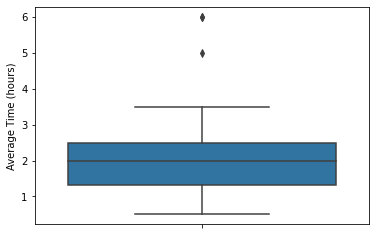

In [24]:
sns.boxplot(data = df, y="Average Time (hours)")

In [ ]:
Using histograms we can see that the distrubutions of these variables are skewed to the right. 

<AxesSubplot:xlabel='Distance (miles)', ylabel='Count'>

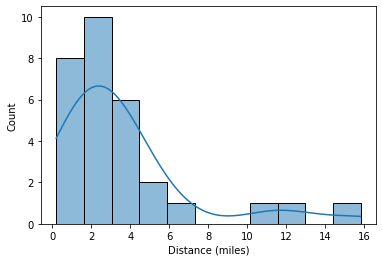

In [34]:
sns.histplot(data = df, x = "Distance (miles)", kde = True)

<AxesSubplot:xlabel='Average Time (hours)', ylabel='Count'>

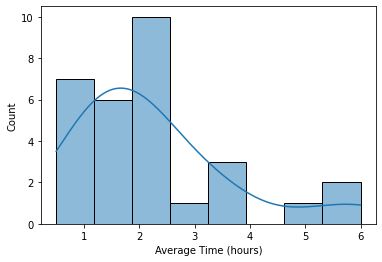

In [33]:
sns.histplot(data = df, x = "Average Time (hours)", kde = True)

<AxesSubplot:ylabel='Count'>

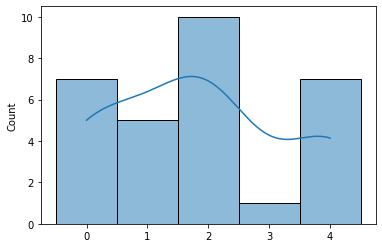

In [36]:
sns.histplot(df , x = sorted(df['Difficulty']), kde = True)

In [ ]:
px.scatter(df, x = "Distance (miles)", y = "Average Time (hours)", 
           color = "Difficulty", color_discrete_sequence = px.colors.qualitative.Set1,template = "plotly_dark")

Looking at this chart it immediatly became clear to me that the samples with a Diffuculty rating of 3 (Strenious), are much different than the trails with lower difficulty ratings. Most ofther ratings have all of their samples seemingly grouped together much more tightly. To further invertigate this, I decided to take a look at the standard deviations when looking at the samples for each individual difficulty rating.  

In [ ]:
df['Difficulty'].unique()

In [ ]:
for x in sorted(df['Difficulty'].unique()):
    print('Difficulty: ' + str(x))
    print(df[df['Difficulty'] == x][['Distance (miles)','Average Time (hours)']].describe().std())

In [ ]:
#This is the part where I should visualize the STD's of each thingy...

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k_means_model = KMeans(n_clusters=5)

In [ ]:
k_means_model.fit(df[['Distance (miles)','Average Time (hours)']])

In [ ]:
k_means_model.labels_

In [ ]:
px.scatter(df, x = "Distance (miles)", y = "Average Time (hours)", 
           color = pd.Series(k_means_model.labels_).astype(str), color_discrete_sequence = px.colors.qualitative.Set1,template = "plotly_dark")

In [ ]:
scaler.fit()

In [ ]:
px.scatter(df, x = "Difficulty", y = "Average Time (hours)")

In [ ]:
px.scatter(df, x = "Difficulty", y = "Distance (miles)")

In [ ]:
px.box(df, y="Difficulty")

In [ ]:
px.box(df, y="Distance (miles)")

In [ ]:
px.box(df, y="Average Time (hours)")